# Определение невыгодных источников трафика сервиса по продаже билетов на развлекательные мероприятия

## План работы:
___
##### [Шаг 1. Загрузка и предобработка данных](#1-link)
##### [Шаг 2. Построение отчетов, расчет метрик](#2-link)
* [Длительность одной сессии](#3-link)
* [Количество пользователей в день, неделю, месяц](#4-link)
* [Ежедневное количество сессий](#5-link)
* [Когортный анализ](#6-link)
* [Анализ продаж](#7-link)
* [Время первой покупки пользователя](#8-link)
* [Количество покупок за период](#9-link)
* [Средний чек](#10-link)
* [LTV - жизненный цикл клиента](#11-link)
* [Сумма затрат на маркетинг (всего / на каждый источник / по времени)](#12-link)
* [ROI - окупаемость расходов на маркетинг](#13-link)
* [Анализ по типам устройств и источников](#14-link)
##### [Шаг 3. Общий вывод](#15-link)

# Шаг 1. Загрузка и предобработка данных<a id='1-link'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

visits = pd.read_csv(r'C:\visits_log.csv')
orders = pd.read_csv(r'C:\orders_log.csv')
costs = pd.read_csv(r'C:\costs.csv')

### Изучение данных

In [2]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [3]:
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [5]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [6]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


In [7]:
costs.head()

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


### Предобработка

Приводим столбцы таблиц visits и orders в нижний регистр и заменяем пробелы на нижние подчеркивания

In [8]:
visits.columns = visits.columns.str.lower()
visits.columns = visits.columns.str.replace(' ', '_')

orders.columns = orders.columns.str.lower()
orders.columns = orders.columns.str.replace(' ', '_')

Изменяем типы столбцов, для последующей обработки

In [9]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'])
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])
costs['dt'] = pd.to_datetime(costs['dt'])

Проверяем таблицы на наличие дубликатов

In [10]:
visits.duplicated().sum()

0

In [11]:
orders.duplicated().sum()

0

In [12]:
costs.duplicated().sum()

0

#### Данные загружены и осуществлена первоначальная обработка на предмет пропусков, дубликатов. корректности форматов.

# Шаг 2. Построение отчетов, расчет метрик<a id='2-link'></a>

### Длительность одной сессии<a id='3-link'></a>

Рассчитаем длительность каждой сессии

In [13]:
visits['duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

Рассчитаем какая доля датафрейма содержит отрицательную или нулевую длительность сеанса

In [14]:
len(visits.loc[visits['duration'] <= 0]) / len(visits['duration'])

0.0995937673900946

Данные составили 9,9% исходного дата фрейма, исключим из анализируемых данных сессии длительность которых равна 0 или отрицательна

In [15]:
visits = visits.query('duration > 0')

In [16]:
visits['duration'].describe()

count    323606.000000
mean        714.684623
std        1047.052806
min          19.000000
25%         120.000000
50%         360.000000
75%         900.000000
max       84480.000000
Name: duration, dtype: float64

В датасете присутствуют подозрительно продолжительные сеансы пользователей, также можно заметить что показатели длительности кратны 1 минуте.

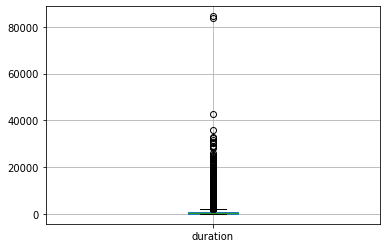

In [17]:
visits.boxplot(column='duration');

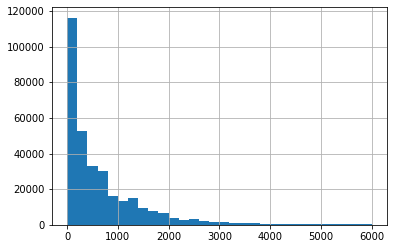

In [18]:
visits['duration'].hist(bins = 30, range=(0, 6000));

Распределение имеет ожидаемую форму, однако присутствуют выбросы с подозрительно длительным временем сеанса

In [19]:
visit_duration_high = visits['duration'].quantile(0.95)
visits_v2 = visits[visits['duration'] < visit_duration_high].copy()

In [20]:
visits_v2['duration'].mean()

540.6353860746497

In [21]:
visits_v2['duration'].mode()

0    60
dtype: int64

Средняя длительность сессии 540 сек, мы выявили аномально длительный сессии, длящиеся несколько часов, мы исключили данные строки из анализируемого датасета. Наиболе часто встречающаяся длительность сессии - 1 минута.

### Количество пользователей в день, неделю, месяц<a id='4-link'></a>

Добавим группировку по дням, неделям и месяцам затрат

In [22]:
visits_v2['visit_day'] = visits_v2['start_ts'].astype('datetime64[D]')
visits_v2['visit_week'] = visits_v2['start_ts'].astype('datetime64[W]')
visits_v2['visit_month'] = visits_v2['start_ts'].astype('datetime64[M]')

Среднее количество уникальных пользователей в день

In [23]:
int(round(visits_v2.groupby(['visit_day'])['uid'].nunique().mean()))

787

Среднее количество уникальных пользователей в неделю

In [24]:
int(round(visits_v2.groupby(['visit_week'])['uid'].nunique().mean()))

5002

Среднее количество уникальных пользователей в месяц

In [25]:
int(round(visits_v2.groupby(['visit_month'])['uid'].nunique().mean()))

20407

* В среднем в день сервис посещает 787 пользователей
* За неделю - 5002 пользователей
* За месяц - 20407 пользователей

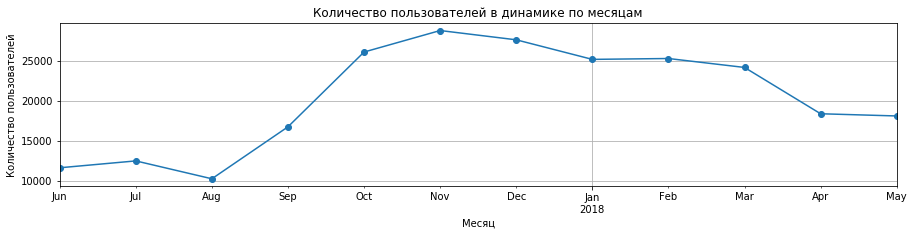

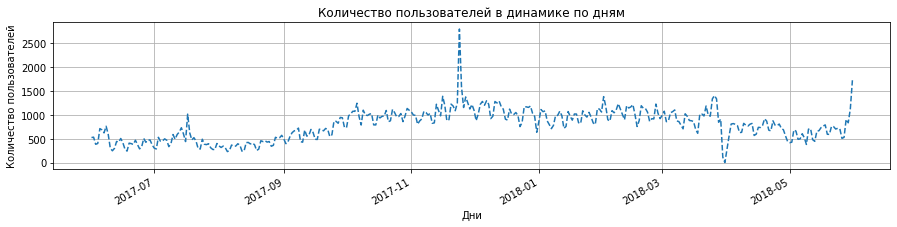

In [26]:
visits_v2.groupby('visit_month').agg({'uid': 'nunique'}).plot(legend = False, grid = True, figsize = (15,3), style = '-o');
plt.title('Количество пользователей в динамике по месяцам');
plt.ylabel('Количество пользователей');
plt.xlabel('Месяц');
plt.show()
visits_v2.groupby('visit_day').agg({'uid': 'nunique'}).plot(legend = False, grid = True, figsize = (15,3), style = '--');
plt.title('Количество пользователей в динамике по дням');
plt.ylabel('Количество пользователей');
plt.xlabel('Дни');

На основе графика по месяцам можно сделать вывод, что сервису свойственна сезонность. Период, когда он наиболее востребован стартует в сентябре и заканчивается в апреле/мае.

### Ежедневное количество сессий<a id='5-link'></a>

Количество сессий в день

In [27]:
int(round(visits_v2.groupby(['visit_day'])['start_ts'].count().mean()))

843

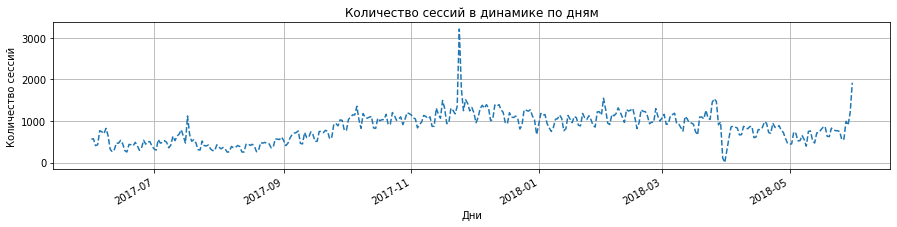

In [28]:
visits_v2.groupby('visit_day').agg({'start_ts': 'count'}).plot(legend = False, grid = True, figsize = (15,3), style = '--');
plt.title('Количество сессий в динамике по дням');
plt.ylabel('Количество сессий');
plt.xlabel('Дни');

### Когортный анализ<a id='6-link'></a>

Определим дату первого визита и добавим эту информацию к таблице visits и orders

In [29]:
first_visit_dates = visits_v2.groupby('uid')['start_ts'].min() 
first_visit_dates.name = 'first_visit_datetime'
visits_v2 = visits_v2.join(first_visit_dates, on='uid')
visits_v2['first_visit_month'] = visits_v2['first_visit_datetime'].astype('datetime64[M]')

Добавим группировку по дням, неделям и месяцам визитов

In [30]:
cohort_visits_month = visits_v2.pivot_table(index='first_visit_month',
    columns='visit_month',
    values='uid',
    aggfunc='nunique').fillna('')

cohort_visits_month

visit_month,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01
first_visit_month,,,,,,,,,,,,
2017-06-01,11645,871,579,690,754,772,663,637,571,567,439,497.0
2017-07-01,,11633,603,570,640,643,533,502,509,430,307,308.0
2017-08-01,,,9088,659,531,522,417,362,315,330,240,214.0
2017-09-01,,,,14843,1193,980,711,555,535,506,339,336.0
2017-10-01,,,,,22987,1713,1126,843,747,694,471,429.0
2017-11-01,,,,,,24160,1816,983,890,770,516,488.0
2017-12-01,,,,,,,22365,1195,790,651,427,387.0
2018-01-01,,,,,,,,20110,1142,751,472,384.0
2018-02-01,,,,,,,,,19796,1058,481,371.0


Далее для расчёта Retention rate найдём периоды жизни когорт: 

In [31]:
visits_v2['cohort_lifetime'] = (visits_v2['visit_month'] - visits_v2['first_visit_month']) / np.timedelta64(1,'M')
visits_v2['cohort_lifetime'] = visits_v2['cohort_lifetime'].astype('float').round().astype('int')

Расчёт Retention rate: 

In [32]:
cohorts = visits_v2.groupby(['first_visit_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [33]:
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]

In [34]:
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

In [35]:
cohorts = cohorts.merge(initial_users_count,on='first_visit_month')

In [36]:
cohorts['first_visit_month'] = cohorts['first_visit_month'].dt.strftime('%Y-%m')

In [37]:
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

In [38]:
retention_pivot = cohorts.pivot_table(index='first_visit_month',columns='cohort_lifetime',values='retention',aggfunc='sum')

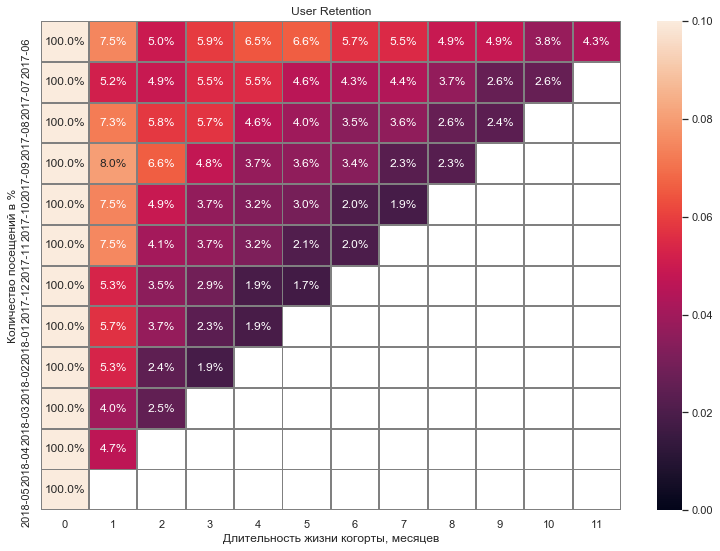

In [39]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=0, vmax=0.10)
plt.ylabel('Количество посещений в %')
plt.xlabel('Длительность жизни когорты, месяцев');

Как мы можем видеть:
- доля людей. которые возвращаются в последствии не превышает 9%,  и в целом имеет тенденцию к снижению в рамках 1 когорты.
- начиная с декабря 2017 года процент вернувшихся людей уже на сл. месяц не превышает 6%.

### Анализ продаж<a id='7-link'></a>

Объединим данные о сеансах и заказах

In [40]:
orders = orders.join(first_visit_dates,on='uid')

Удалим строки продаж по пользователям, о которых нет информации о первом визите

In [41]:
orders = orders.dropna()

Создадим таблицу в которой определим для каждого пользователя устройство и идентификатор источника привлечения соответствующий его первому визиту

Определим дату первого заказа и добавим эту информацию к таблице orders

In [42]:
first_order_date_by_customers = orders.groupby('uid')['buy_ts'].min()
first_order_date_by_customers.name = 'first_order_date'
orders = orders.join(first_order_date_by_customers,on='uid')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')

Добавим группировку по дням, неделям и месяцам покупок

In [43]:
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders['order_week'] = orders['buy_ts'].astype('datetime64[W]')
orders['order_day'] = orders['buy_ts'].astype('datetime64[D]')

Добавим информацию о времени прошедшем от первого визита до первой покупки к таблице orders

In [44]:
orders['time_to_order'] = (orders['first_order_date'] - orders['first_visit_datetime']).dt.seconds

In [45]:
correct_buyers = orders

### Время первой покупки пользователя<a id='8-link'></a>

In [46]:
print('Среднее время до первой покупки пользователем', round((correct_buyers['time_to_order'].mean() / 60), 2), 'минут')
print('Медианное время до первой покупки пользователем ', correct_buyers['time_to_order'].median() / 60, 'минут')

Среднее время до первой покупки пользователем 310.67 минут
Медианное время до первой покупки пользователем  18.0 минут


### Количество покупок за период<a id='9-link'></a>

In [47]:
print('Среднее количество покупок в день', int(round(correct_buyers.groupby('order_day')['uid'].nunique().mean())))
print()
print('Среднее количество покупок в неделю', int(round(correct_buyers.groupby('order_week')['uid'].nunique().mean())))
print()
print('Среднее количество покупок в месяц', int(round(correct_buyers.groupby('order_month')['uid'].nunique().mean())))
print()

Среднее количество покупок в день 122

Среднее количество покупок в неделю 775

Среднее количество покупок в месяц 2980



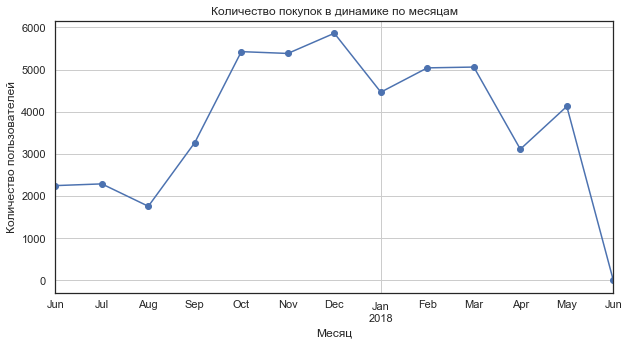

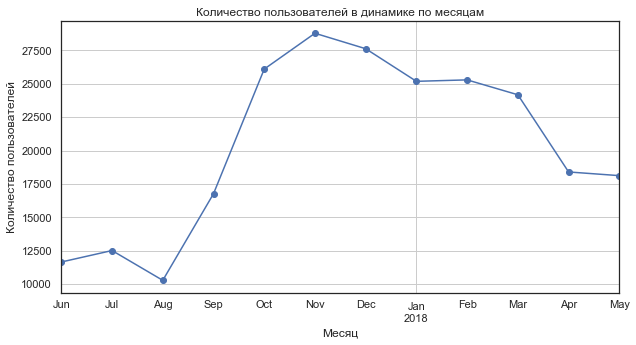

In [48]:
correct_buyers.groupby('order_month').agg({'uid': 'count'}).plot(legend = False, grid = True, figsize = (10,5), style = '-o')
plt.title('Количество покупок в динамике по месяцам')
plt.ylabel('Количество пользователей')
plt.xlabel('Месяц')
plt.show()
visits_v2.groupby('visit_month').agg({'uid': 'nunique'}).plot(legend = False, grid = True, figsize = (10,5), style = '-o')
plt.title('Количество пользователей в динамике по месяцам')
plt.ylabel('Количество пользователей')
plt.xlabel('Месяц');
plt.show()

Динамика покупок и количество активных пользователей коррелируют между собой.

Для расчета среднего количества покупок посчитаем разделим количество пользователей на количество покупок за идентичный период

In [49]:
 orders['uid'].count() / orders['uid'].nunique()

1.4007230742317336

### Средний чек<a id='10-link'></a>

In [50]:
correct_buyers['revenue'].describe()

count    48042.000000
mean         5.012724
std         22.169388
min          0.000000
25%          1.220000
50%          2.440000
75%          4.890000
max       2633.280000
Name: revenue, dtype: float64

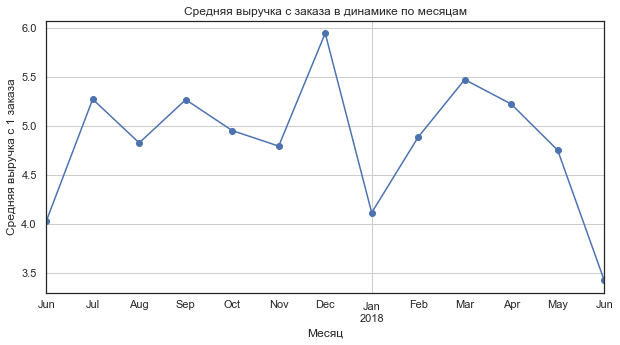

In [51]:
correct_buyers.groupby('order_month').agg({'revenue': 'mean'}).plot(legend = False, grid = True, figsize = (10,5), style = '-o')
plt.title('Средняя выручка с заказа в динамике по месяцам')
plt.ylabel('Средняя выручка с 1 заказа')
plt.xlabel('Месяц');

Средний чек равен 5.01. Динамику изменения данного показателя мы можем наблюдать на графике выше, наибольшее значение было достигнутов декабре 2017 года и превысило 6, в среднем показатель находится в интервале 4.5 - 5.5, однако в январе и июне 2018 он опустился ниже 4.5.

### LTV - жизненный цикл клиента<a id='11-link'></a>

##### Когортный анализ продаж

In [52]:
first_orders = correct_buyers.groupby('uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['uid', 'first_order_month']

Считаю количество новых пользователй за каждый месяц (n_buyers):

In [53]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']

Для построения когорт добавляю месяц первой покупки каждого покупателя в orders:

In [54]:
orders_new = pd.merge(correct_buyers,first_orders, on='uid')


Группирую таблицу заказов по месяцу первой покупки и месяцу каждого заказа и складываю выручку:

In [55]:
cohorts_orders = correct_buyers.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()

Добавляю в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [56]:
report = pd.merge(cohort_sizes, cohorts_orders, on='first_order_month')

Добавляю в report возраст когорты:

In [57]:
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report['first_order_month'] = report['first_order_month'].dt.strftime('%Y-%m')

##### Расчет LTV

In [58]:
report['gp'] = report['revenue'] * 1
report['ltv'] = report['gp'] / report['n_buyers']

In [59]:
result = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2)

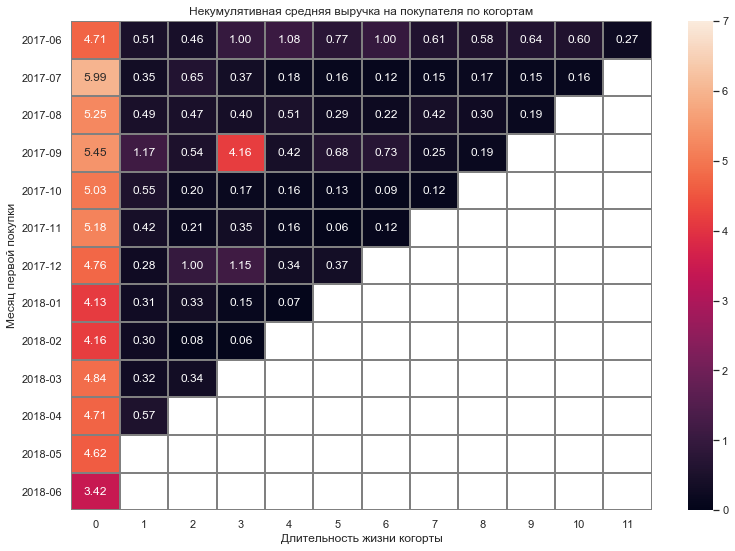

In [60]:
plt.figure(figsize=(13, 9))
plt.title('Некумулятивная средняя выручка на покупателя по когортам')
sns.heatmap(result, annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin=0, vmax=7)
plt.ylabel('Месяц первой покупки')
plt.xlabel('Длительность жизни когорты');

Как мы видим по тепловой карте основная выручка сервиса формируется во время первого заказа пользователя. Пользователи используют сервис крайне редко, о чем говорит резкое падение выручки в рамках когорты в последующие месяцы.

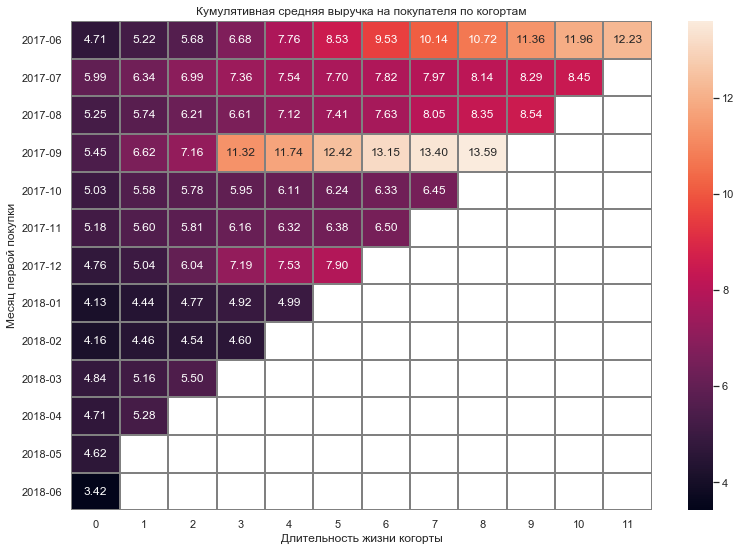

In [61]:
cum_result = result.cumsum(axis = 1)
plt.figure(figsize=(13, 9))
plt.title('Кумулятивная средняя выручка на покупателя по когортам')
sns.heatmap(cum_result, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.ylabel('Месяц первой покупки')
plt.xlabel('Длительность жизни когорты');

На тепловой карте видно, что наиболее прибыльными для Афиши были поользователи когорты 2017-09 и 2017-06

### Сумма затрат на маркетинг (всего / на каждый источник / по времени)<a id='12-link'></a>

Всего на маркетинг было потрачено

In [62]:
costs['costs'].sum()

329131.62

Добавим группировку по дням, неделям и месяцам затрат

In [63]:
costs['costs_day'] = costs['dt'].astype('datetime64[D]')
costs['costs_week'] = costs['dt'].astype('datetime64[W]')
costs['costs_month'] = costs['dt'].astype('datetime64[M]')

Потрачено на каждый источник траффика

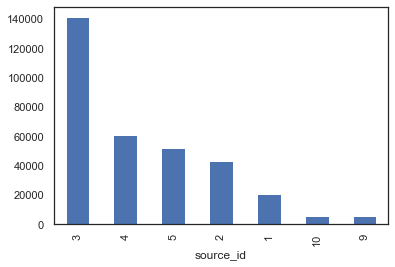

In [64]:
costs.groupby('source_id')['costs'].sum().sort_values(ascending=False).plot(kind='bar');

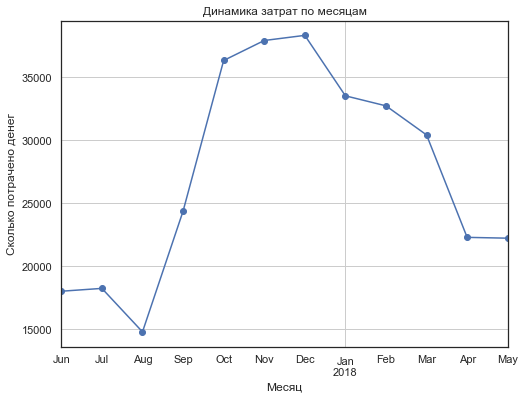

In [65]:
costs.groupby('costs_month')['costs'].sum().plot(figsize = (8, 6), grid = True, style = '-o')
plt.title('Динамика затрат по месяцам')
plt.ylabel('Сколько потрачено денег')
plt.xlabel('Месяц');

Заметен рост затрат во второй половине года и максимальными значениями в ноябре-декабре.

##### Подготовка данных для анализа по типам устройств и источников

Создадим таблицу с информацией о типе устройства и источнике при первом посещении ресурса, для последующего анализа затрат

In [66]:
users_info = visits_v2.query('first_visit_datetime == start_ts')
users_info = users_info.loc[:, ["uid", "device", "source_id"]].drop_duplicates()
users_info['uid'].duplicated().sum()

0

In [67]:
orders_info = correct_buyers.merge(users_info,on='uid')
orders_info['first_order_date'] = orders_info['first_order_date'].astype('datetime64[M]')

Рассчитаем ежемесячные данные о кол-ве уникальных пользователей, сумме выручки в разрезе источников и объединим с данными о ежемесячных затратах

In [68]:
orders_by_month = orders_info.groupby(['first_order_date', 'source_id']).agg({'uid':'nunique','revenue':'sum'}).reset_index()
costs_by_month = costs.groupby(['costs_month', 'source_id']).agg({'costs':'sum'}).reset_index()
costs_and_orders_by_month = orders_by_month.merge(costs_by_month, left_on=['first_order_date', 'source_id'], right_on=['costs_month', 'source_id'], )

Расходы на 1 покупателя по рекламным источникам

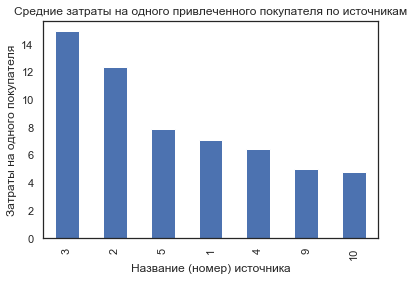

In [69]:
costs_per_uid = costs_and_orders_by_month.groupby('source_id').agg({'costs':'sum', 'uid':'sum'})
costs_per_uid['cac'] = costs_per_uid['costs'] / costs_per_uid['uid']
costs_per_uid['cac'].sort_values(ascending=False).plot(kind='bar');
plt.title('Средние затраты на одного привлеченного покупателя по источникам')
plt.xlabel('Название (номер) источника')
plt.ylabel('Затраты на одного покупателя');

Наибольшая стоимость привлечения одного покупателя для сервиса оказалась у источников №3 и №2. Наименьшая у источника №10. 

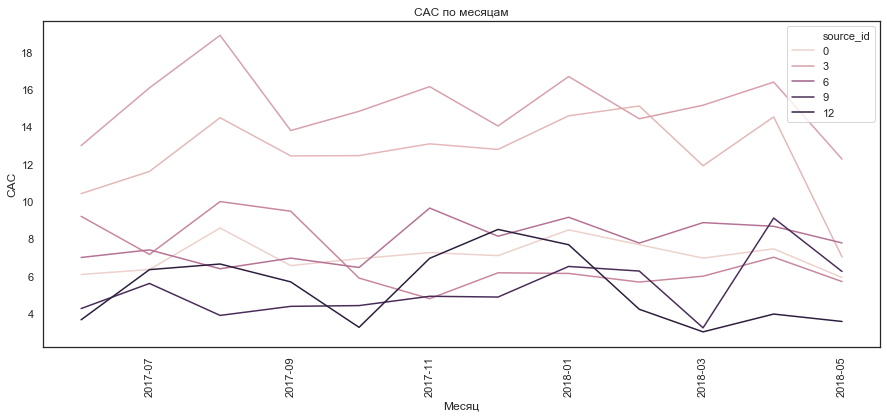

In [70]:
cac_per_month = costs_and_orders_by_month.groupby(['costs_month', 'source_id']).agg({'costs':'sum', 'uid':'sum'}).reset_index()
cac_per_month['cac'] = cac_per_month['costs'] / cac_per_month['uid']

plt.subplots(figsize=(15,6))
plt.xticks(rotation=90)
sns.lineplot(x="costs_month", y="cac", data=cac_per_month, hue='source_id');
plt.title('CAC по месяцам')
plt.xlabel('Месяц')
plt.ylabel('CAC');


#### Наибольший показатель CAC зафикисирован в августе 2017 по всем видам источников, также заметно что САС двух источников на протяжении рассматриваемого периода выше, чем остальных.

### ROI - окупаемость расходов на маркетинг<a id='13-link'></a>

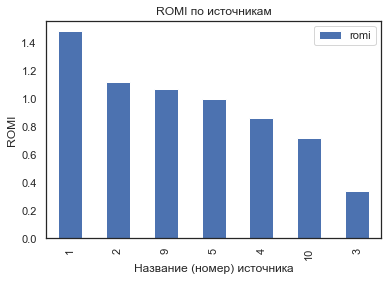

In [71]:
costs_and_orders_by_source = costs_and_orders_by_month.groupby('source_id').sum().reset_index()
costs_and_orders_by_source['romi'] = (costs_and_orders_by_source['revenue']) / (costs_and_orders_by_source['costs'])
costs_and_orders_by_source.sort_values(ascending=False, by='romi').plot(kind='bar', y='romi', x='source_id');
plt.title('ROMI по источникам')
plt.xlabel('Название (номер) источника')
plt.ylabel('ROMI');

Лучше всего затраты окупились по источнику 1, хуже всего по источнику 3, при этом средние затраты на покупателя для 3 источника самые высокие, а на 1 - средние. Маркетологам стоит рассмотреть вариант перераспределения бюджета в соответствии с это информацией.

##### Когортный анализ ROMI

In [72]:
monthly_costs = costs.groupby('costs_month').sum().reset_index()

In [73]:
monthly_costs['costs_month'] = monthly_costs['costs_month'].dt.strftime('%Y-%m')

In [74]:
costs_cohort = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='costs_month')

In [75]:
costs_cohort['cac'] = costs_cohort['costs'] / costs_cohort['n_buyers']
costs_cohort['romi'] = costs_cohort['ltv'] / costs_cohort['cac']

In [76]:
mean_romi = costs_cohort.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean').cumsum(axis=1).round(2)


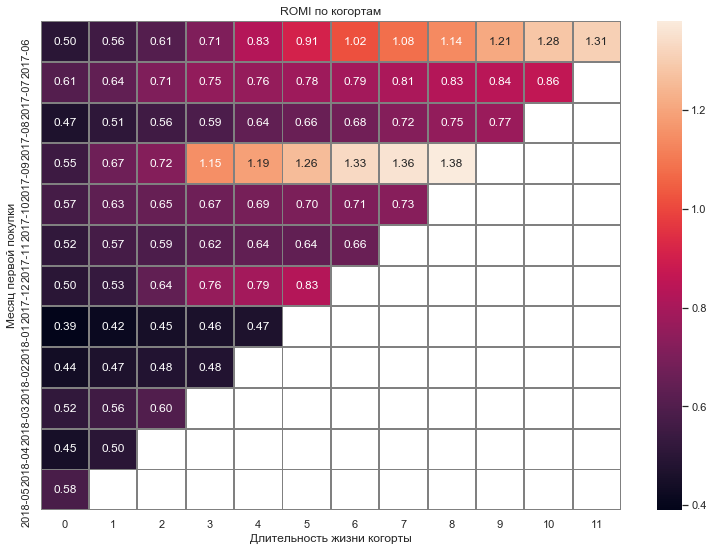

In [77]:
plt.figure(figsize=(13, 9))
plt.title('ROMI по когортам')
sns.heatmap(mean_romi, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.ylabel('Месяц первой покупки')
plt.xlabel('Длительность жизни когорты');

Окупились только 2 когорты: 1-я июньская и 4-я сентябрьская. Причем в 4й когорте самый быстрый срок окупаемости: всего на 4й месяц.

### Анализ продаж в разрезе типов устройств<a id='14-link'></a>

In [78]:
monthly_orders_by_device = orders_info.groupby(['first_order_month', 'device']).agg({'uid':'nunique','time_to_order': 'count', 'revenue':'sum'}).reset_index()
monthly_orders_by_device.rename(columns={'time_to_order': 'purchase_count', 'uid' : 'n_unique_uid'}, inplace=True)
monthly_orders_by_device['avg_purchase'] = monthly_orders_by_device['revenue'] / monthly_orders_by_device['purchase_count']

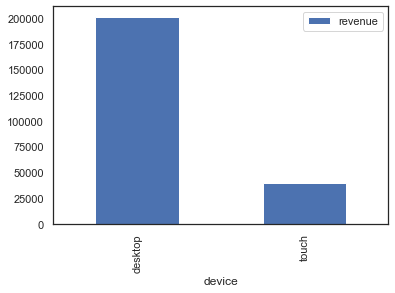

In [79]:
monthly_orders_by_device.pivot_table(index='device', values='revenue', aggfunc='sum').plot(kind='bar');

Среднемесячное количество покупок и сумма выручки в разрезе устройств

In [80]:
avg_sales = monthly_orders_by_device.groupby('device').agg({'purchase_count' : 'mean', 'revenue' : 'mean'})
avg_sales['avg_purchase'] = avg_sales['revenue'] / avg_sales['purchase_count']
avg_sales

,purchase_count,revenue,avg_purchase
device,,,
desktop,2996.000000,15476.805385,5.165823
touch,757.833333,3301.900833,4.357028


##### Анализ затрат

In [81]:
avg_purchase_by_cat = orders_info.groupby(['source_id', 'device']).agg({'device' : 'count', 'revenue' : 'sum'})
avg_purchase_by_cat.rename(columns={'device': 'purchase_count'}, inplace=True)
avg_purchase_by_cat = avg_purchase_by_cat.reset_index()
avg_purchase_by_cat['avg_purchace'] = avg_purchase_by_cat['revenue'] / avg_purchase_by_cat['purchase_count']

Средняя сумма чека в разрезе источников

In [82]:
avg_purchase_by_cat.pivot_table(index='source_id', columns='device', values='avg_purchace', aggfunc='sum').sort_values(by='desktop', ascending=False)

device,desktop,touch
source_id,,
2,7.932599,6.123010
5,5.966938,3.791852
1,5.944999,4.916873
4,4.341520,4.465657
3,4.015204,3.790586
9,3.530951,3.199832
10,2.998458,2.395719


Количество покупателей в разрезе источников

In [83]:
avg_purchase_by_cat.pivot_table(index='source_id', columns='device', values='purchase_count', aggfunc='sum').sort_values(by='desktop', ascending=False)

device,desktop,touch
source_id,,
3,9955,2065
4,9166,2839
5,7750,1447
2,5106,1196
1,4425,937
9,1398,297
10,1148,313


###### Вывод 1: 
Средний чек покупки выше у desktop по всем источникам траффика, кроме 4. Количество покупок выше в desktop.

###### Вывод 2: 
- Заложить больший бюджет на развитие 2, 5 и 1 источников, т.к. CAC по ним меньше чем для 3, а размер среднего чека выше
- Снизить финансирование 3 источника, т.к. CAC самый высокий а сумма среднего чека ниже средней.

# Вывод<a id='15-link'></a>

<br><b> Показатели посещаемости</b>

* В среднем в день сервис посещает 907 пользователей
* За неделю - 5825 пользователей
* За месяц - 23228 пользователей
* В среднем в день проходит 987 сессий.
* Средняя длительность сессии составляет 10 минут при этом у 50% пользователей длительность сессии меньше 6 минут.

<br><b> Выводы о посещаемости</b>
* Во втором месяце в каждой когорте резко снижается количество пользователей, что говорит о неругулярном характере посещения сервиса.
* Темп снижения оттока пользователей после 2-го месяца существенно замедляется, но динамика снижения сохраняется практически во всех когортах в длительном периоде.

<br><b> Показатели покупок</b>

* Медианное время между первым визитом отдельного пользователя и покупкой 18 минут.
* В среднем за месяц пользователи делают 2980 покупку.
* Средняя выручка с покупателя с типом устройства desktop = 5.16, а с touch = 4.35
* Число покупателей с устройством desktop существенно выше (2996), чем покупателей с устройством  touch (757)</font>

<br><b> Экономические показатели</b>

* Средняя выручка сервиса с заказа - 5 рублей при этом более 75% значения расположены ниже уровня 4,89 рубля за заказ.
* Совокупные расходы сервиса на привлечение составили 329 т.р. Это больше, чем совокупная выручка - 252 т.р.
* Заметен рост затрат во второй половине года с максимальными значениями в ноябре-декабре, что совпадает с динамикой по выручке и количеству визитов в это же время.
* Окупились только 2 когорты: 1-я июньская и 4-я сентябрьская. При этом у 4-й когорты самый быстрый срок окупаемости, он существенно ниже среднего.

На основе проанализированных данных мой совет маркетологам такой: необходимо развивать направление touch устройств, необходимо пересмотреть распределение по типам источников в пользу источников с наиболее высоким чеком и наименьшим CAC. Снижение затрат необходимо, т.к. расходы на привлечение не окупаются последующими покупками.

Регулярность посещения сервиса крайне острая проблема, необходимо найти подход к текущим клиентам, например, индивидуальная система скидок на мероприятия, которые находятся в зоне интересов покупателя.